<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/BK_debug-plotting/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip uninstall -y wavefilter
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-th7d9z47/wavefilter_8ac45955456a482199de35ea4d53f995
  Running command git clone --filter=blob:none --quiet https://github.com/benkrikler/wavefilter /tmp/pip-install-th7d9z47/wavefilter_8ac45955456a482199de35ea4d53f995
  Resolved https://github.com/benkrikler/wavefilter to commit a79156fdac2e2b9376efad3d7c0a01b569a8bcce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=10444 sha256=971eb1f8978b5cdc57796968c9b1a10bdfcb847b3027062300d97126d9717f39
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmebkbur/wheels/69/e1/5a/14ea7df73ed74f41654cc8ed1fda7a952887d233e0e8cc942d
Successfully built wavefilter


In [5]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import pandas as pd
import logging
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder
from wavefilter.inspect import InspectActivations
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
wavefilter.evaluate.logging.basicConfig(level=logging.INFO)

Using cuda device


In [7]:
# from importlib import reload
# reload(wavefilter.inspect)
# reload(wavefilter)

## Make some data

In [8]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data

array([[-1.1683327 ,  5.63978   ,  0.80669695, ...,  3.6290038 ,
         0.13432513, -1.5954937 ],
       [-0.7482525 ,  0.5646925 ,  0.25810423, ...,  2.1110485 ,
        -0.31156185, -1.5332222 ],
       [ 1.2600378 ,  0.88767457, -2.7191877 , ...,  0.441459  ,
         2.0528462 ,  1.356241  ],
       ...,
       [ 0.5447825 , -0.26716682, -1.4917015 , ...,  0.9715221 ,
         0.83948845, -0.75765175],
       [-1.3841742 ,  5.295449  , -1.6131098 , ..., -3.4386344 ,
        -3.7228758 , -2.1913502 ],
       [-0.7452911 ,  1.6040251 , -0.4626778 , ...,  1.694668  ,
        -2.7752004 ,  4.291974  ]], dtype=float32)

In [9]:
ds = wds.to_torch_dataset(data)
train_loader = torch.utils.data.DataLoader(ds, batch_size=100, shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f78f4a3aa40>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f78f4a3cbd0>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f78f4a3cc20>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f78f4a3cb80>)]


## Set up the model

In [155]:
class LocalMaxFinder(nn.Module):
    def __init__(self, window_size):
      super().__init__()
      self.window_size = window_size
      self.pooler = nn.MaxPool1d(window_size, stride=1, return_indices=True)
      self.unpooler = nn.MaxUnpool1d(window_size, stride=1)

    def forward(self, waveform):
      maxima, indices = self.pooler(waveform)
      return self.unpooler(maxima, indices, output_size=(waveform.size(-1),))
    
class Conv1dPulseFinderAttention_v4(models.Conv1dPulseFinderAttentionBase):
    def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)
      self.first_scale = torch.nn.Conv1d(1, 1, 5, padding="same")
      self.local_max = LocalMaxFinder(50)

    def forward(self, ampl: torch.Tensor, original: torch.Tensor):
        inputs = super().forward_step1(ampl, original)
        inputs = torch.roll(inputs, self.pf_length //2, -1)
       # scale = self.scale(inputs)
       # attend = torch.tanh(F.softshrink(scale))
       # return F.softmax(attend, -1)
        #attend = F.leaky_relu(inputs)
        attend = inputs
        attend = self.local_max(attend) - 10
        attend = torch.roll(attend, self.pf_length //2, -1)
        attend = self.first_scale(attend)
        attend = torch.sigmoid(attend)
        #attend = F.softmax(attend, -1)
        attend = self.scale(attend)
        attend = F.leaky_relu(attend)
        return attend

attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", Conv1dPulseFinderAttention_v4(50, True), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention_v4(
      (pulse_finder): Conv1d(1, 1, kernel_size=(50,), stride=(1,), padding=same)
      (combine): Conv1d(3, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
      (first_scale): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=same)
      (local_max): LocalMaxFinder(
        (pooler): MaxPool1d(kernel_size=50, stride=1, padding=0, dilation=1, ceil_mode=False)
        (unpooler): MaxUnpool1d(kernel_size=(50,), stride=(1,), padding=(0,))
      )
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


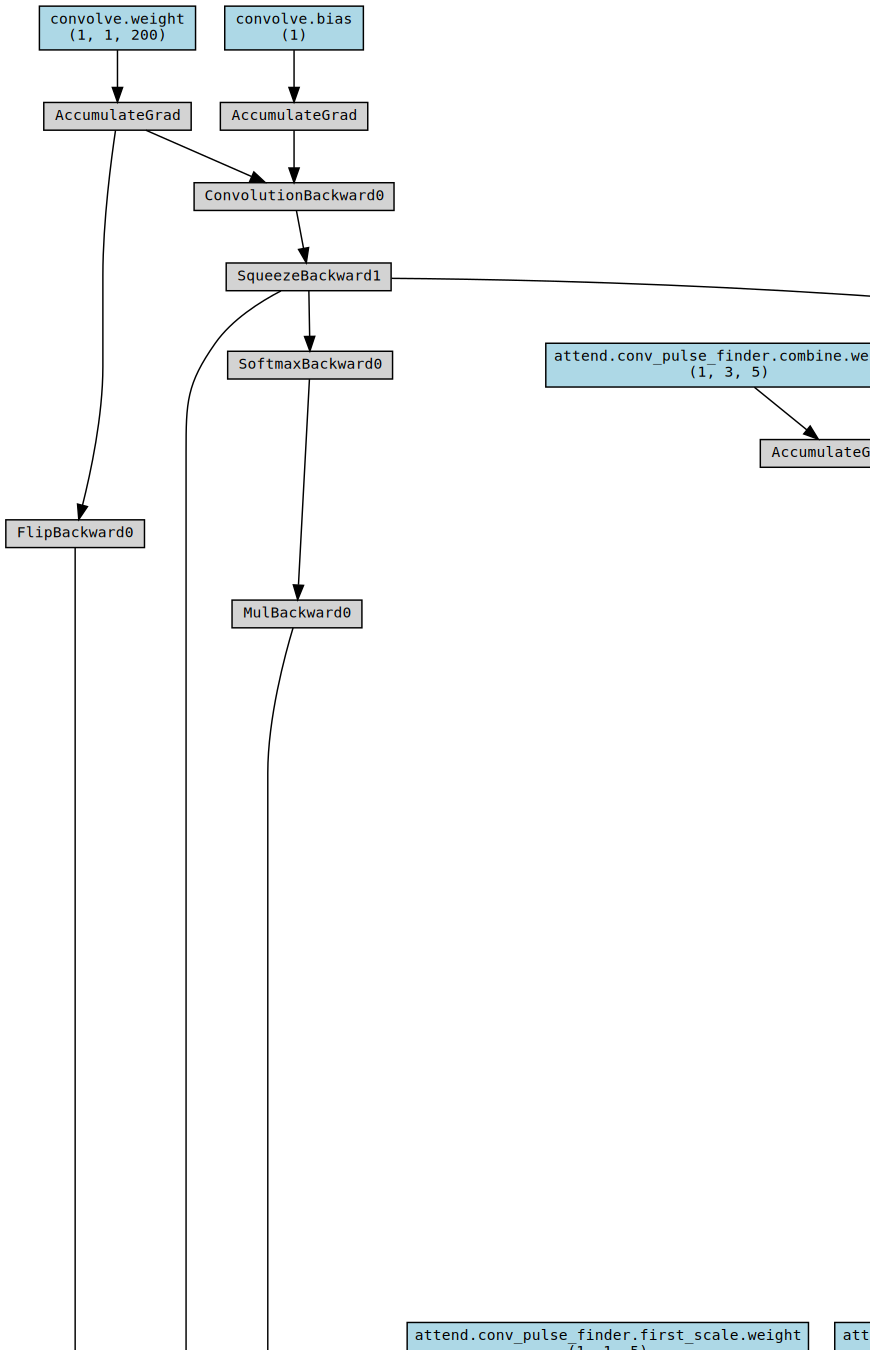

In [156]:
##    If a node represents a backward function, it is gray. Otherwise, the node
##   represents a tensor and is either blue, orange, or green:
##    - Blue: reachable leaf tensors that requires grad (tensors whose `.grad`
##        fields will be populated during `.backward()`)
##    - Orange: saved tensors of custom autograd functions as well as those
##        saved by built-in backward nodes
##    - Green: tensor passed in as outputs
##    - Dark green: if any output is a view, we represent its base tensor with
##        a dark green node.
make_dot(model(ds[0][0].to(device)), params=dict(list(model.named_parameters())))

## Train our model

In [157]:
params = split_parameters(model, ['attend'])
[[tuple(t.shape) for t in p["params"]] for p in params]

[[(1, 1, 50), (1,), (1, 3, 5), (1,), (1, 1, 1), (1,), (1, 1, 5), (1,)],
 [(1, 1, 200), (1,), (1,)]]

In [158]:
lr_schedules = [lambda x: 0.99, lambda x: 0.95**x]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=params,
                                     lr_schedules=lr_schedules, device=device,
                                     epochs=500,
                                     start_incrementing = 20,
                                     epochs_per_increment = 40,
                                     change_per_increment = 0.20,
)

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

## Inspect what we've learnt

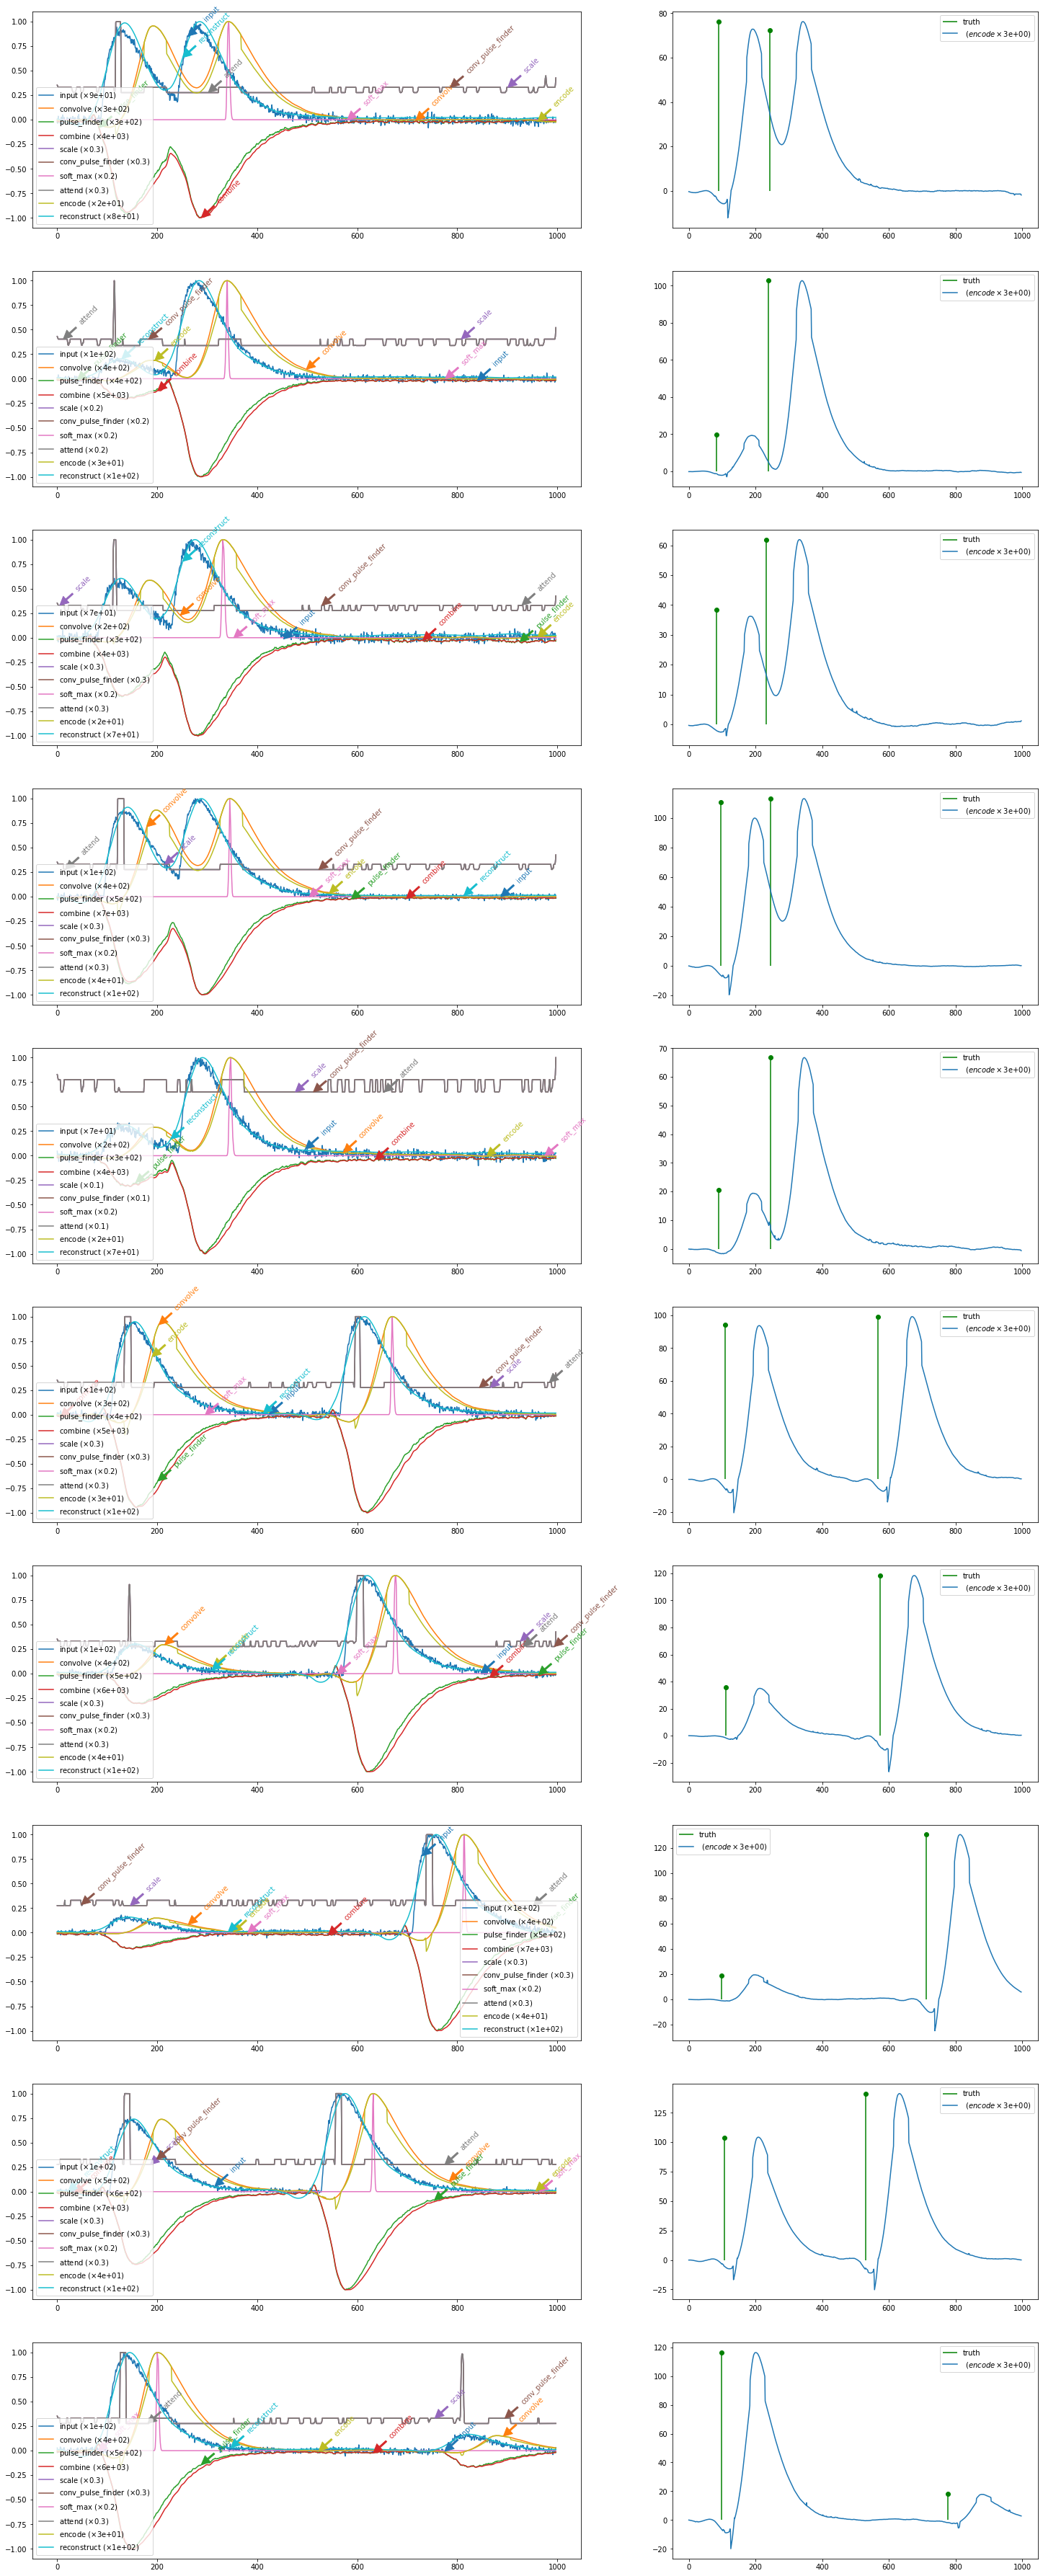

In [159]:
activations = InspectActivations(device)
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
activations.inspect(model, ds, true_amp=truth[0], true_time=truth[1], indices=choices, compare_truth="encode")

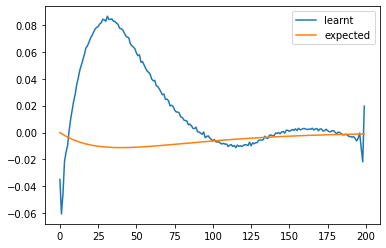

In [160]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

-4.0746784

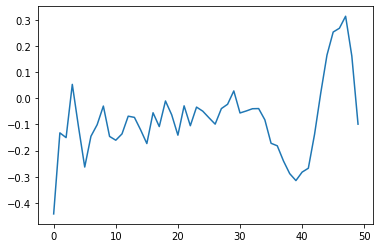

In [161]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

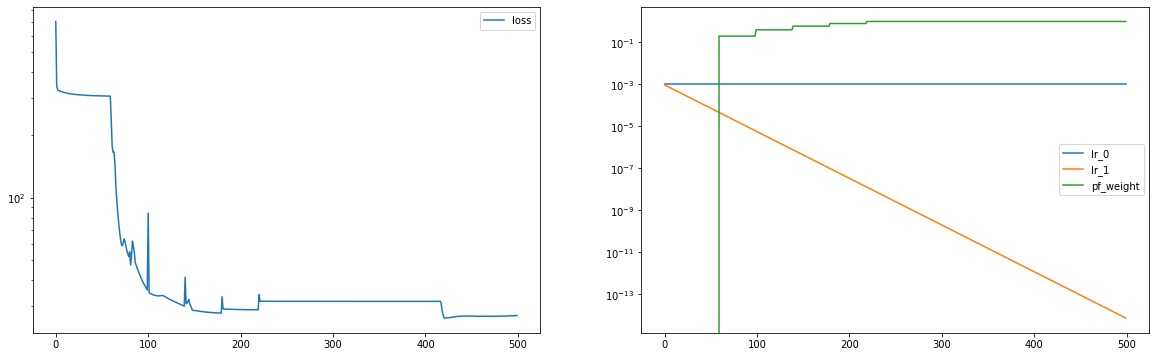

In [162]:
_, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(tester.train["loss"], label="loss");
ax[0].legend()
ax[0].set_yscale("log")
for name in ["lr_0", "lr_1", "pf_weight"]:
    ax[1].plot(tester.train[name], label=name);
ax[1].set_yscale("log")
ax[1].legend()

In [129]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[6.6510e-02, 3.3173e-02, 4.4666e-02, 6.4458e-02, 6.7121e-02,
          6.9709e-02, 7.8728e-02, 8.4652e-02, 8.9338e-02, 9.4380e-02,
          9.7811e-02, 1.0340e-01, 1.0687e-01, 1.1143e-01, 1.1384e-01,
          1.1658e-01, 1.1993e-01, 1.2427e-01, 1.2533e-01, 1.2734e-01,
          1.3019e-01, 1.3185e-01, 1.3415e-01, 1.3617e-01, 1.3755e-01,
          1.3822e-01, 1.3853e-01, 1.4115e-01, 1.4256e-01, 1.4195e-01,
          1.4196e-01, 1.4441e-01, 1.4441e-01, 1.4384e-01, 1.4622e-01,
          1.4395e-01, 1.4578e-01, 1.4571e-01, 1.4496e-01, 1.4442e-01,
          1.4400e-01, 1.4550e-01, 1.4408e-01, 1.4278e-01, 1.4367e-01,
          1.4308e-01, 1.4152e-01, 1.4089e-01, 1.4113e-01, 1.4091e-01,
          1.3764e-01, 1.3853e-01, 1.3796e-01, 1.3616e-01, 1.3514e-01,
          1.3474e-01, 1.3361e-01, 1.3160e-01, 1.3250e-01, 1.3093e-01,
          1.2872e-01, 1.2829e-01, 1.2860e-01, 1.2567e-01, 1.2556e-01,
          1.2377e-01, 1.2306e-01, 1.2084e-01, 1.21

In [130]:
model.attend.module_weights

{'conv_pulse_finder': 1.0, 'soft_max': -5.551115123125783e-17}